# PYMC

**我们可以完全吧pymc的model想象成一个tensorflow的computation graph**    

*Model - computation graph*,  *Variable - tensor*

既然吧，都是一些tensor和计算图的东西了，我们暂且假定这个东西不支持eager execution                 
Model 相当于是一个session，你的变量啥的都要在model这个里面定义               
在外面定义就出错了                        

In [1]:
import pymc3 as pm

with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0)
    data_generator = pm.Poisson("data_generator", parameter)

你只要在with 上面创建的model，就可以在那个model里面继续工作了

In [4]:
with model:
    data_plus_one = data_generator + 1

在model外面看到里面定义变量的值

In [5]:
parameter.tag.test_value

array(0.69314718)

重新定义了一个pm.Model()，名字也叫model

In [6]:
with pm.Model() as model:
    theta = pm.Exponential("theta", 2.0)
    data_generator = pm.Poisson("data_generator", theta)

给model起一个名字

In [7]:
with pm.Model() as ab_testing:
    p_A = pm.Uniform("P(A)", 0, 1)
    p_B = pm.Uniform("P(B)", 0, 1)

PYMC的每一个变量都是有一个初始值的

In [8]:
print("parameter.tag.test_value =", parameter.tag.test_value)
print("data_generator.tag.test_value =", data_generator.tag.test_value)
print("data_plus_one.tag.test_value =", data_plus_one.tag.test_value)

parameter.tag.test_value = 0.6931471824645996
data_generator.tag.test_value = 0
data_plus_one.tag.test_value = 1


创建变量的时候，是可以创建一个初始值的

In [9]:
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0, testval=0.5)

print("\nparameter.tag.test_value =", parameter.tag.test_value)


parameter.tag.test_value = 0.5


### 变量类型    
- 随机变量是用来产生随机数的     
- 确定性变量是用来进行一些其他幺蛾子计算的 - 是由其他的变量决定的【不是一个常量】   

In [11]:
with pm.Model() as model:
    some_variable = pm.DiscreteUniform("discrete_uni_var", 0, 4)

你看，shape的定义像不像tensor

In [13]:
with model:
    betas = pm.Uniform("betas", 0, 1, shape=(3,3,4))

如果我们想要跟踪这个Deterministic的值，我们就必须显式定义这个变量，要用theano        

遗憾的是我现在不会theano

In [17]:
# with model:
#     cac = pm.Deterministic('sddf')

In [14]:
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)
    tau = pm.DiscreteUniform("tau", lower=0, upper=10)

new_deterministic_variable = lambda_1 + lambda_2

在折腾一个Deterministic的时候，我们可以各种把stochastic加减乘除一顿做

In [18]:
def subtract(x, y):
    return x - y


with pm.Model() as model:
    stochastic_1 = pm.Uniform("U_1", 0, 1)
    stochastic_2 = pm.Uniform("U_2", 0, 1)

    det_1 = pm.Deterministic("Delta", subtract(stochastic_1, stochastic_2))

## Theano 还是挺恶心的


The majority of the heavy lifting done by PyMC3 is taken care of with the theano package. The notation in theano is remarkably similar to NumPy. It also supports many of the familiar computational elements of NumPy. However, while NumPy directly executes computations, e.g. when you run a + b, theano instead builds up a "compute graph" that tracks that you want to perform the + operation on the elements a and b. Only when you eval() a theano expression does the computation take place (i.e. theano is lazy evaluated). Once the compute graph is built, we can perform all kinds of mathematical optimizations (e.g. simplifications), compute gradients via autodiff, compile the entire graph to C to run at machine speed, and also compile it to run on the GPU. PyMC3 is basically a collection of theano symbolic expressions for various probability distributions that are combined to one big compute graph making up the whole model log probability, and a collection of inference algorithms that use that graph to compute probabilities and gradients. For practical purposes, what this means is that in order to build certain models we sometimes have to use theano.

Let's write some PyMC3 code that involves theano calculations.

这个拼接向量的操作，实属骚操作

In [19]:
import theano.tensor as tt

with pm.Model() as theano_test:
    p1 = pm.Uniform("p", 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    
    assignment = pm.Categorical("assignment", p)

想要用好pymc，最好还是掌握一下theano的底层API

### 上面定义了一堆随机数，下面就要加入观测数据了

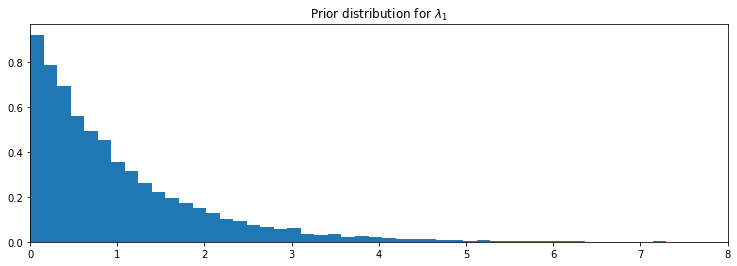

In [22]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
figsize(12.5, 4)

# 在这个model里面，我们定义一个lambda 1 和一个 lambda 2
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)
    tau = pm.DiscreteUniform("tau", lower=0, upper=10)

new_deterministic_variable = lambda_1 + lambda_2

samples = lambda_1.random(size=20000)
plt.hist(samples, bins=70, density=True, histtype="stepfilled")
plt.title("Prior distribution for $\lambda_1$")
plt.xlim(0, 8);

**划重点， random 方法加上size这个参数，是可以产生随机数的，产生出来的东西是numpy**

In [25]:
lambda_1.random(size = 10)

array([0.13097432, 1.41056818, 2.65050332, 0.35435405, 1.5294509 ,
       1.23654896, 0.27850541, 0.0615001 , 0.34099019, 0.41194122])

In [26]:
type(lambda_1.random(size = 10))

numpy.ndarray

1. 我们要用numpy或者pandas的数据作为observation进去
2. Stochastic variable 有一个 `observed` 参数，用来接受观测数据

In [28]:
import numpy as np

# 你看，这儿有一个numpy
data = np.array([10, 5])

with model:
    # 这是一个随机变量，给了几个观测值
    fixed_variable = pm.Poisson("fxd", 1, observed=data)
print("value: ", fixed_variable.tag.test_value)

value:  [10  5]


In [33]:
# We're using some fake data here
data = np.array([10, 25, 15, 20, 35])

# 在这个model里面，我们定义一个lambda 1 和一个 lambda 2
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)
    tau = pm.DiscreteUniform("tau", lower=0, upper=10)

# 在同一个model里面，我们定义一个lambda_ [deterministic]
with model:
    idx = np.arange(5) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
# 我们给了一个参数，给了observed_data  
data = np.array([10, 25, 15, 20, 35])
with model:
    obs = pm.Poisson("obs", lambda_, observed=data)
    
print(obs.tag.test_value)

[10 25 15 20 35]
[10 25 15 20 35]


上面那一出，其实我也不知道自己在干什么，我只想说明下面这个，加入obsertvation， 仅此而已

In [35]:
# 我们给了一个参数，给了observed_data  
data = np.array([10, 25, 15, 20, 35])
with pm.Model() as model:
    obs = pm.Poisson("obs", 1, observed=data)
    
print(obs.tag.test_value)

[10 25 15 20 35]


## 问自己： 观测数据到底是怎么产生的

1. 问自己： 什么样的随机变量最适合描述 - **计数**， 柏松分布，所以我们把每日收到的短信看作是一个柏松分布采样出来的
2. 问自己： 假设这个分布确实是柏松分布， 那我需要什么才能构造一个柏松分布， 我们需要它的参数 λ.
3. 问自己： 我们知道播送分布的这个参数 λ 么， 不，我们怀疑这个参数在某个时间发生了变化，前面有一个 λ1， 后面有一个 λ2， 这个前后的转折点(switch point) 我们记为 τ。
4. 问自己： 这些λs用什么东西描述最适合，因为柏松分布的参数是一个正数， 那指数分布刚好就可以描述这个东西， 指数分布给正实数赋了一个概率值。但是指数分布也有一个参数，叫做α。
5. 问自己： 我们知道指数分布的参数α么，我们不知道，我们可以也把一个随机的分布赋值给α，但是我们停停把，我们对参数λ有一个先验的估计，λ可能是随着时间变化的，大概实在10 - 30 之间， 我们对于α这个东西，确实没有什么很有信心的估计。所以我们就停在这儿把。那怎么样更好的设置α呢，如果α太小，那么产生大数字的概率就不较大，不能很好反应我们对λ的估计，同样，太大也不行，也反应不好。一个很好的估计是设置一个alpha， 让lambda等于观测数据的平均值。
6. 问自己： 我们对τ能够很好的估计么，不能，所以我们假设τ能够出现在时间线上的任何一点， discrete uniformly.

我们把上面的步骤反过来，就能够构造一个数据集

In [38]:
tau = np.random.randint(0, 80)
print(tau)

26


In [41]:
alpha = 1./20.
lambda_1, lambda_2 = np.random.exponential(scale=1/alpha, size=2)
print(lambda_1, lambda_2)

28.274559342942872 23.77056266715186


In [42]:
data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size = 80 - tau)]

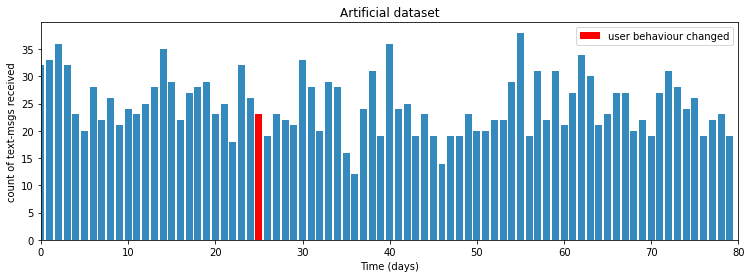

In [44]:
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau-1, data[tau - 1], color="r", label="user behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();

我们试着多构造几个数据集，并把他们画出来图， 这玩意儿对贝叶斯很有用的

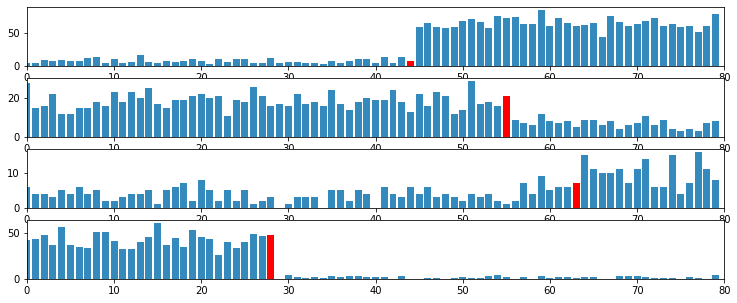

In [45]:
def plot_artificial_sms_dataset():
    tau = stats.randint.rvs(0, 80)
    alpha = 1./20.
    lambda_1, lambda_2 = stats.expon.rvs(scale=1/alpha, size=2)
    data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size=80 - tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau - 1, data[tau-1], color="r", label="user behaviour changed")
    plt.xlim(0, 80);

figsize(12.5, 5)
plt.title("More example of artificial datasets")
for i in range(4):
    plt.subplot(4, 1, i+1)
    plot_artificial_sms_dataset()

## 废话全去掉，看一个简单的购买率

首先我们并不知道这个购买率，我们假设这个购买率是一个随机变量， 一个连续的随机变量。

In [46]:
import pymc3 as pm

# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

我们一顿模拟丫的

In [62]:
#set constants
p_true = 0.05  # remember, this is unknown.
N = 4000

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = stats.bernoulli.rvs(p_true, size=N)

print(occurrences) # Remember: Python treats True == 1, and False == 0
print(np.sum(occurrences))

[0 0 0 ... 0 1 0]
209


然后我们把上面模拟出来的观测数据加入到模型中

In [63]:
# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

with model:
    
    # 我们观测到的是一组0，1 的伯努利事件， 这个伯努利是由一个continuous的概率p(前面定义的)控制的
    obs = pm.Bernoulli("obs", p, observed=occurrences)
    
    # 来了一个metropolis， 这个东西就是在产生随机数的过程中trace一些变量
    step = pm.Metropolis()
    
    # 我们从posteria中sample，然后搞事情，这个要到第三章才能讲
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

/Users/huan/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]


Sampling 4 chains for 1_000 tune and 18_000 draw iterations (4_000 + 72_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.


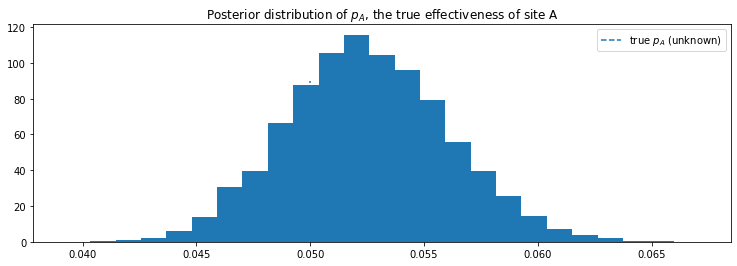

In [64]:
figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", density=True)
plt.legend();

## 看两个网站的购买率是否有差异

两个网站，两个转化率，两组样本观测值

In [65]:
import pymc3 as pm
figsize(12, 4)

#these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")

Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [66]:
print(np.mean(observations_A))
print(np.mean(observations_B))

0.04933333333333333
0.032


In [67]:
# 首先构造一个模型
with pm.Model() as model:
    
    # 然后把两个转化率做成变量
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # 然后做两个样本之间的差值
    delta = pm.Deterministic("delta", p_A - p_B)

    # 使用转化率产生伯努利序列
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    # 带入模型求解 【别管先】
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]

/Users/huan/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 26 seconds.
The number of effective samples is smaller than 25% for some parameters.


拿出来的东西都是numpy

In [68]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

老哥喜欢画图

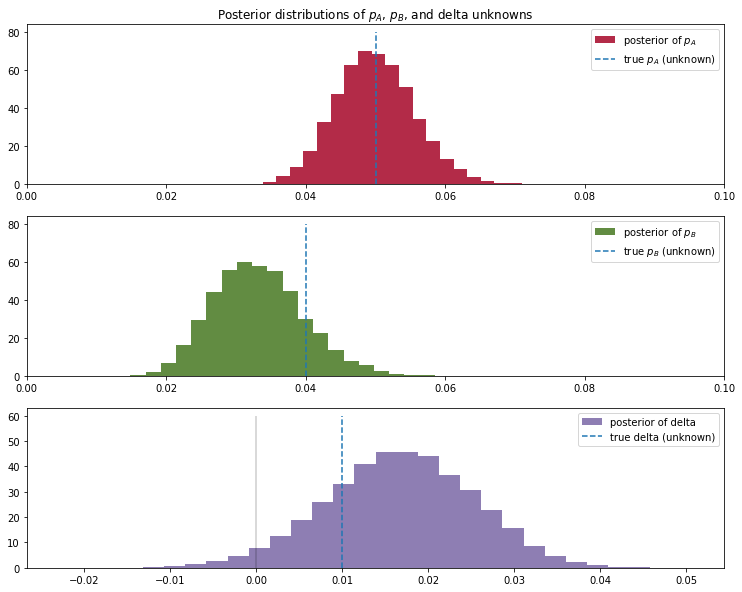

In [71]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [72]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.031
Probability site A is BETTER than site B: 0.969


## 快看， 二项分布

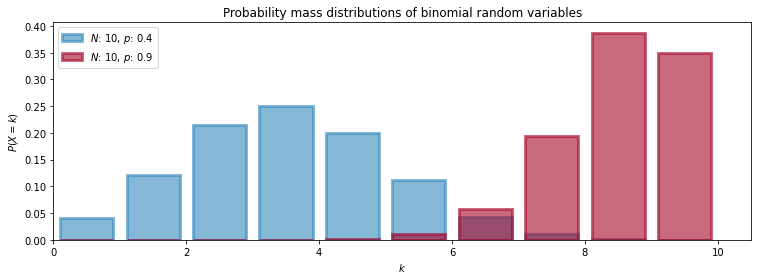

In [73]:
figsize(12.5, 4)

import scipy.stats as stats
binomial = stats.binom

parameters = [(10, .4), (10, .9)]
colors = ["#348ABD", "#A60628"]

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N + 1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i],
            edgecolor=colors[i],
            alpha=0.6,
            label="$N$: %d, $p$: %.1f" % (N, p),
            linewidth=3)

plt.legend(loc="upper left")
plt.xlim(0, 10.5)
plt.xlabel("$k$")
plt.ylabel("$P(X = k)$")
plt.title("Probability mass distributions of binomial random variables");

## 你作弊了没

你， 抛一个硬币，如果正面，你就必须回答这次考试作弊了没，诚实。                           
如果是反面，你再抛一个，                      
    - 如果这次是正面， 你说，我作弊了             
    - 如果这次是反面， 你说，我没作弊      
那么请问， 作弊率是多少

*那么首先，我们要求的就是这个，作弊率*

In [75]:
import pymc3 as pm

N = 100
with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)
    
# 这些人每个人心中都知道自己的正确答案是什么    
with model:
    true_answers = pm.Bernoulli("truths", p, shape=N, testval=np.random.binomial(1, 0.5, N))
    
# 抛一个硬币， 看正面还是反面    
with model:
    first_coin_flips = pm.Bernoulli("first_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))
    
# 抛两个硬币，看正面还是反面
with model:
    second_coin_flips = pm.Bernoulli("second_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))
    
    
print(first_coin_flips.tag.test_value)


import theano.tensor as tt

with model:
    # 最后收集到多少个作弊的样本
    # 如果第一枚是正面，且作弊了，你就是1了， 如果第一次是反面，第二次是正面，这样你也可以收到一个1
    val = first_coin_flips*true_answers + (1 - first_coin_flips)*second_coin_flips
    
    # 最后算一下 1 的占比就好了
    # 因为我们需要最后追踪这个比例，我们用Deterministic， 这个其实就是一个生成的概率
    observed_proportion = pm.Deterministic("observed_proportion", tt.sum(val)/float(N))
    
# 假设真实的调查中，你收集到了35份样本    
X = 35

with model:
    # 用上面这个生成的概率，做一个二项分布，看看最后能得到多少个作弊样本，和实际收到的X个样本对比一下
    observations = pm.Binomial("obs", N, observed_proportion, observed=X)

[0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1
 0 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1 1 1
 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1]


然后用一个奇怪的模型，走一波， 风扇呼呼呼的转，我的电脑恐怕是要不行了

In [77]:
# To be explained in Chapter 3!
# with model:
#     step = pm.Metropolis(vars=[p])
#     trace = pm.sample(40000, step=step)
#     burned_trace = trace[15000:]

老哥喜欢画图

In [78]:
# figsize(12.5, 3)
# p_trace = burned_trace["freq_cheating"][15000:]
# plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
#          label="posterior distribution", color="#348ABD")
# plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
# plt.xlim(0, 1)
# plt.legend();

## Arrays of PYMC3 variables

In [79]:

N = 10
x = np.ones(N, dtype=object)
with pm.Model() as model:
    for i in range(0, N):
        x[i] = pm.Exponential('x_%i' % i, (i+1.0)**2)